

В июне был запущен новый функционал и теперь необходимо отследить, как это повлияло на аудиторию. Если аудитория не приняла нововведение, то лучше сразу от него отказаться либо внести изменения.

__Задача__:
- Для понимания эффективности нового функционала нужно посчитать показатели Retention и ARPU за два периода: за май (до введения функционала) и июнь (после).


In [2]:
# импортируем нужные библиотеки
%matplotlib inline
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 

# Блок данных за МАЙ

In [3]:
# функция, которая считает , сколько пользователей зарегистрировалось в каждый день мая.

def getRegisteredUsersCount():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

registered_users_count = pd.DataFrame(getRegisteredUsersCount())

In [4]:
registered_users_count.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31 entries, 0 to 30
Data columns (total 2 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   registration_date       31 non-null     object
 1   registered_users_count  31 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 624.0+ bytes


In [5]:
# Меняем тип данных для дат на datetime
registered_users_count['registration_date'] = pd.to_datetime(registered_users_count['registration_date'])
registered_users_count.head()

,registration_date,registered_users_count
0,2019-05-01,6516
1,2019-05-02,5309
2,2019-05-03,6266
3,2019-05-04,8639
4,2019-05-05,9787


In [6]:
# Найдем кол-во пользователей, зарегистрировавшихся в мае
registered_users_count['registered_users_count'].sum()

188943

### Сколько пользователей вернулось в игру?
Итак, мы получили количество пользователей, зарегистрировавшихся в игре. Но какое количество из них вернулось в игру в дальнейшем?

Для этого мы можем посчитать количество активных пользователей в __разрезе когорт__. В этом случае в качестве когорты будет выступать дата регистрации. Таким образом, можно получить количество активных пользователей по дням в разрезе даты регистрации
- Давайте получим данные об активных пользователях из базы и подсчитаем по дням количество активных пользователей active_users_count с указанием даты регистрации registration_date. Напомним, что дата регистрации будет выступать когортой.
Метод получения данных будет аналогичен предыдущему пункту. Создадим функцию getActiveUsersCountWithCohorts() и затем запишем данные, полученные с помощью этой функции, в датафрейм active_users_count_with_cohorts

In [7]:
# функция запрашивает данные за МАЙ об активных пользователях из базы и подсчитаем по дням количество активных 
# пользователей active_users_count с указанием даты регистрации registration_date.
def getActiveUsersCountWithCohorts():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data


In [8]:
# Запишем данные за май в DataFrame
active_users_count_with_cohorts = pd.DataFrame(getActiveUsersCountWithCohorts())
active_users_count_with_cohorts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 961 entries, 0 to 960
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   activity_date       961 non-null    object
 1   registration_date   961 non-null    object
 2   active_users_count  961 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 22.6+ KB


In [9]:
# преобразуем колонки с датами в тип datetime
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts[col] = pd.to_datetime(active_users_count_with_cohorts[col])
active_users_count_with_cohorts.head()

,activity_date,registration_date,active_users_count
0,2019-05-01,2019-05-01,2590
1,2019-05-02,2019-05-01,2146
2,2019-05-02,2019-05-02,2049
3,2019-05-03,2019-05-01,1637
4,2019-05-03,2019-05-02,1817


In [10]:
#Таблица для расчета retention rate за МАЙ
retention_table = active_users_count_with_cohorts.merge(registered_users_count,on=['registration_date'],how='left')
retention_table['retention_rate'] = retention_table['active_users_count'] / retention_table['registered_users_count']
retention_table.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-05-01,2019-05-01,2590,6516,0.397483
1,2019-05-02,2019-05-01,2146,6516,0.329343
2,2019-05-02,2019-05-02,2049,5309,0.385948
3,2019-05-03,2019-05-01,1637,6516,0.251228
4,2019-05-03,2019-05-02,1817,5309,0.342249


In [11]:
# какое количество дней прошло с момента регистрации до определенного дня активности
retention_table['lifetime'] = retention_table['activity_date'] - retention_table['registration_date']
# нам нужно получить целое количество дней. 
# Для этого мы можем значения в колонке с типом timedelta разделить на константу np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime']/np.timedelta64(1,'D')
retention_table['lifetime'] = retention_table['lifetime'].astype(int) # Приведем тип к целому числу
retention_table['lifetime'].head()

0    0
1    1
2    0
3    2
4    1
Name: lifetime, dtype: int32

In [12]:
# Создадим сводную таблицу retention за МАЙ
retention_pivot = retention_table.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-05-01,0.397483,0.329343,0.251228,0.222683,0.198895,0.174954,0.153929,0.146255,0.133671,0.123082,...,0.072284,0.069828,0.068754,0.067219,0.067373,0.063536,0.062922,0.060773,0.043738,0.029619
2019-05-02,0.385948,0.342249,0.254285,0.219062,0.193633,0.164061,0.152006,0.140328,0.125071,0.117160,...,0.067056,0.059522,0.059898,0.061217,0.060652,0.058768,0.055943,0.053682,0.045018,0.031456
2019-05-03,0.381264,0.339291,0.256783,0.219438,0.188477,0.170124,0.148899,0.142834,0.132301,0.126716,...,0.071976,0.070859,0.072455,0.069103,0.067028,0.066550,0.063837,0.060166,0.046920,0.030961
2019-05-04,0.384651,0.335224,0.241232,0.191573,0.169348,0.150249,0.140178,0.137284,0.131728,0.116796,...,0.072925,0.071420,0.066906,0.065401,0.064012,0.061465,0.058456,0.057646,0.043176,0.029286
2019-05-05,0.383161,0.311944,0.227751,0.192398,0.170737,0.152549,0.145397,0.138755,0.121488,0.113518,...,0.067641,0.063962,0.061101,0.060693,0.058547,0.057014,0.053438,0.054256,0.043936,0.027179
2019-05-06,0.368205,0.312260,0.227748,0.191377,0.162809,0.147732,0.137680,0.130274,0.117445,0.105806,...,0.065997,0.062029,0.060045,0.055680,0.053829,0.050919,0.049597,0.048142,0.035048,0.021690
2019-05-07,0.366349,0.326020,0.239393,0.206808,0.172770,0.153251,0.142926,0.137280,0.124859,0.113405,...,0.070657,0.062591,0.063559,0.060816,0.058235,0.057106,0.057590,0.055815,0.041781,0.028392
2019-05-08,0.393985,0.328271,0.245564,0.198195,0.176241,0.156692,0.142707,0.132782,0.121353,0.110977,...,0.066316,0.063910,0.058195,0.056842,0.053534,0.053835,0.052632,0.048872,0.038496,0.026617
2019-05-09,0.377529,0.320909,0.236777,0.205183,0.180866,0.163649,0.147497,0.136138,0.124068,0.113774,...,0.067093,0.066205,0.061945,0.060703,0.058218,0.055201,0.053958,0.054846,0.045971,0.029464


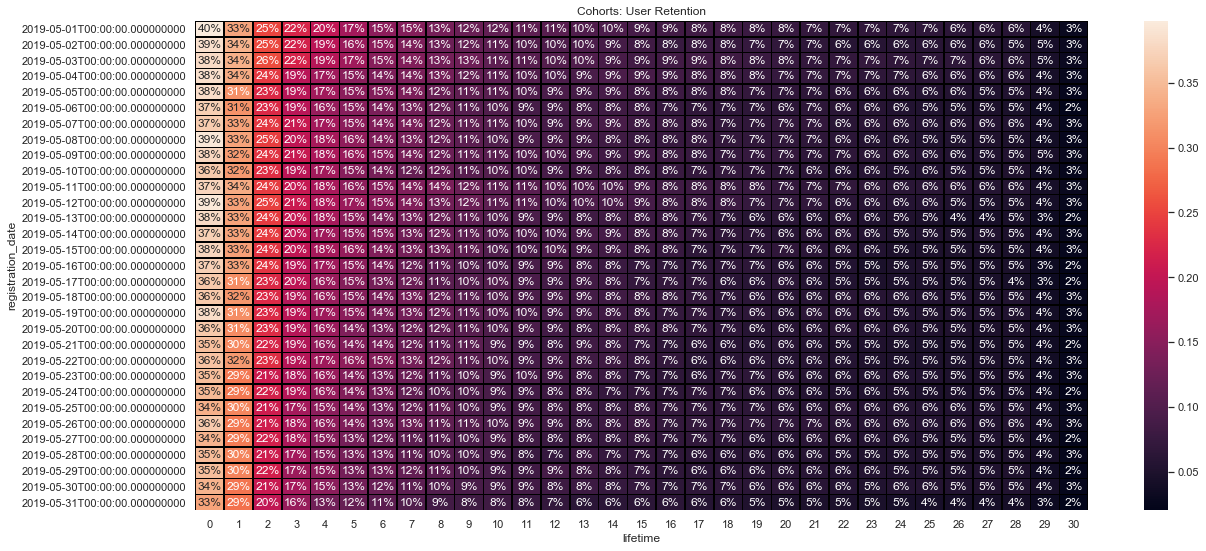

In [13]:
# Такую таблицу удобно визуализировать с помощью heatmap в библиотеке seaborn:

import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: User Retention')
sns.heatmap(retention_pivot, mask=retention_pivot.isnull(), annot=True, fmt='.0%', linewidths=0.5, linecolor='black');

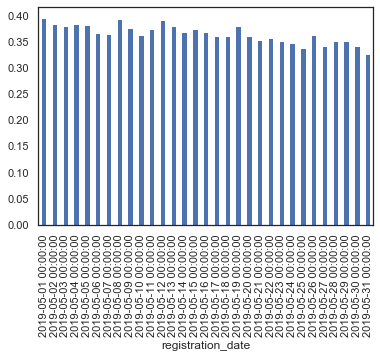

In [14]:
# построим как в зависимости от когорты изменяется Retention Rate на 0-й день:
retention_pivot[0].plot.bar()

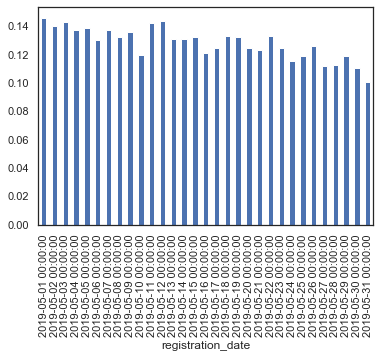

In [15]:
# построим как в зависимости от когорты изменяется Retention Rate на 7-й день в МАЕ:
retention_pivot[7].plot.bar()

In [16]:
# Найдем относительное изменение Retention Rate на 0-й день в когорте 31 мая 2019 г. относительно когорты 1 мая 2019 г
print('Относительное изменение Retention Rate на 0-й день в когорте 31 мая относительно 1 мая {:.2%}'.format(retention_pivot[0]['2019-05-31']/retention_pivot[0]['2019-05-01']))
# Найдем относительное изменение Retention Rate на 7-й день в когорте 31 мая 2019 г. относительно когорты 1 мая 2019 г
print('Относительное изменение Retention Rate на 7-й день в когорте 31 мая относительно 1 мая {:.2%}'.format(retention_pivot[7]['2019-05-31']/retention_pivot[7]['2019-05-01']))

Относительное изменение Retention Rate на 0-й день в когорте 31 мая относительно 1 мая 82.28%
Относительное изменение Retention Rate на 7-й день в когорте 31 мая относительно 1 мая 68.89%


#### Выводы за май: Таким образом, мы можем говорить о том, что Retention Rate с течением времени ухудшается.

## Считаем ARPU за май

In [17]:
# выручку по дням в разрезе когорт, для пользователей, зарегистрировавшихся в мае 2019 г. Этот запрос обернем функцию getRevenue().
def getRevenue():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-05-01' and r.registration_date < '2019-06-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
revenue = pd.DataFrame(getRevenue())
# Произведем преобразование типов к datetime
for col in ['date','registration_date']:
    revenue[col] = pd.to_datetime(revenue[col])
revenue.head()

,date,registration_date,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,1672,2357.590
1,2019-05-02,2019-05-01,1420,514.679
2,2019-05-02,2019-05-02,1367,1629.140
3,2019-05-03,2019-05-01,1048,390.952
4,2019-05-03,2019-05-02,1164,533.608


In [18]:
# Считаем среднюю выручку за МАЙ
print(registered_users_count['registered_users_count'].sum())

# Считаем среднюю выручку за 30 дней с пользователя, зарегистрировашегося в МАЕ
revenue['revenue'].sum()/registered_users_count['registered_users_count'].sum()

188943


0.6456883713606749

In [19]:
# Объединяем DataFrame revenue и retention_rate для расчета ARPU за МАЙ

revenue = revenue.rename(columns={'date':'activity_date'})
retention_table_with_revenue = retention_table.merge(revenue,on=['registration_date','activity_date'],how='left')
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672.0,2357.590
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420.0,514.679
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367.0,1629.140
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048.0,390.952
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164.0,533.608


In [20]:
retention_table_with_revenue.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 961 entries, 0 to 960
Data columns (total 8 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   activity_date             961 non-null    datetime64[ns]
 1   registration_date         961 non-null    datetime64[ns]
 2   active_users_count        961 non-null    int64         
 3   registered_users_count    961 non-null    int64         
 4   retention_rate            961 non-null    float64       
 5   lifetime                  961 non-null    int32         
 6   users_count_with_revenue  912 non-null    float64       
 7   revenue                   912 non-null    float64       
dtypes: datetime64[ns](2), float64(3), int32(1), int64(2)
memory usage: 63.8 KB


In [21]:
# Произведем замену пропущенных значений на 0 с помощью функции fillna():
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue[col] = retention_table_with_revenue[col].fillna(0)
    
# Преобразуем тип в колонке users_count_with_revenue в целочисленный
retention_table_with_revenue['users_count_with_revenue'] = retention_table_with_revenue['users_count_with_revenue'].astype(int)

In [22]:
# Рассчитываем ARPU за МАЙ
retention_table_with_revenue['arpu'] = retention_table_with_revenue['revenue'] / retention_table_with_revenue['active_users_count'] 
retention_table_with_revenue.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu
0,2019-05-01,2019-05-01,2590,6516,0.397483,0,1672,2357.590,0.910266
1,2019-05-02,2019-05-01,2146,6516,0.329343,1,1420,514.679,0.239832
2,2019-05-02,2019-05-02,2049,5309,0.385948,0,1367,1629.140,0.795090
3,2019-05-03,2019-05-01,1637,6516,0.251228,2,1048,390.952,0.238822
4,2019-05-03,2019-05-02,1817,5309,0.342249,1,1164,533.608,0.293675


# Блок данных за ИЮНЬ. Самостоятельная работа

### Retention rate:
- Рассчитайте для каждого дня lifetime усредненный Retention Rate по всем когортам июня 2019 г.
- Постройте график изменения среднего Retention Rate в июне 2019 г. в зависимости от времени жизни пользователя.
- Опишите, какие выводы можно сделать на основе графика изменения Retention Rate.

In [23]:
# функция, которая считает , сколько пользователей зарегистрировалось в каждый день июня.

def getRegisteredUsersCountJune():
    query = '''SELECT r.registration_date, count(distinct(r.user_id)) as registered_users_count
    FROM case9.registration r
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1
    '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
# Находим данные об активности пользователей в июне
registered_users_count_june = pd.DataFrame(getRegisteredUsersCountJune())
registered_users_count_june['registration_date'] = pd.to_datetime(registered_users_count_june['registration_date'])

registered_users_count_june.head()

,registration_date,registered_users_count
0,2019-06-01,4833
1,2019-06-02,5255
2,2019-06-03,4193
3,2019-06-04,4194
4,2019-06-05,3998


In [24]:
# Найдем кол-во пользователей, зарегистрировавшихся в июне
registered_users_count_june['registered_users_count'].sum()

100423

__Найдем кол-во активных пользователей за ИЮНЬ в разрезе когорт__

In [25]:
# Найдем данные об активных пользователях за ИЮНЬ из базы и подсчитаем по дням количество активных пользователей active_users_count 
# с указанием даты регистрации registration_date
def getActiveUsersCountWithCohortsJune():
    query = '''SELECT ac.activity_date, r.registration_date, count(distinct(ac.user_id)) as active_users_count
    FROM case9.user_activity ac
    LEFT JOIN case9.registration r ON r.user_id = ac.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

active_users_count_with_cohorts_june = pd.DataFrame(getActiveUsersCountWithCohortsJune())
for col in ['activity_date','registration_date']:
    active_users_count_with_cohorts_june[col] = pd.to_datetime(active_users_count_with_cohorts_june[col])
active_users_count_with_cohorts_june.head()

,activity_date,registration_date,active_users_count
0,2019-06-01,2019-06-01,1651
1,2019-06-02,2019-06-01,1429
2,2019-06-02,2019-06-02,1933
3,2019-06-03,2019-06-01,1021
4,2019-06-03,2019-06-02,1550


In [26]:
# Какое количество активных пользователей было зафиксировано на 10 июня 2019 для пользователей, зарегистрировавшихся 1 июня 2019 г.?
active_users_count_with_cohorts_june[(active_users_count_with_cohorts_june.activity_date == '2019-06-10') &
                                    (active_users_count_with_cohorts_june.registration_date == '2019-06-01')].sum()

activity_date         2019-06-10 00:00:00
registration_date     2019-06-01 00:00:00
active_users_count                    483
dtype: object

In [27]:
#Таблица для расчета retention rate за ИЮНЬ
retention_table_june = active_users_count_with_cohorts_june.merge(registered_users_count_june,on=['registration_date'],how='left')
retention_table_june['retention_rate'] = retention_table_june['active_users_count'] / retention_table_june['registered_users_count']
retention_table_june.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate
0,2019-06-01,2019-06-01,1651,4833,0.341610
1,2019-06-02,2019-06-01,1429,4833,0.295676
2,2019-06-02,2019-06-02,1933,5255,0.367840
3,2019-06-03,2019-06-01,1021,4833,0.211256
4,2019-06-03,2019-06-02,1550,5255,0.294957


In [28]:
# Какой Retention Rate наблюдается на 18 июня 2019 г. у пользователей когорты, зарегистрировавшихся 3 июня 2019 г.? 

round(retention_table_june[(retention_table_june.registration_date == '2019-06-03') &
                    (retention_table_june.activity_date == '2019-06-18')].retention_rate*100,2)

155    7.68
Name: retention_rate, dtype: float64

__Считаем lifetime за ИЮНЬ__

In [29]:
# Добавим к данным за июнь столбец lifetime
retention_table_june['lifetime'] = retention_table_june['activity_date'] - retention_table_june['registration_date']
# нам нужно получить целое количество дней. 
# Для этого мы можем значения в колонке с типом timedelta разделить на константу np.timedelta64(1,'D')
retention_table_june['lifetime'] = retention_table_june['lifetime']/np.timedelta64(1,'D')
retention_table_june['lifetime'] = retention_table_june['lifetime'].astype(int) # Приведем тип к целому числу

# Создадим сводную таблицу retention для июня.
retention_pivot_june = retention_table_june.pivot_table(index='registration_date',columns='lifetime',values='retention_rate',aggfunc='sum')
retention_pivot_june

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.341610,0.295676,0.211256,0.175667,0.143596,0.134906,0.121664,0.112766,0.110904,0.099938,...,0.060418,0.061246,0.058763,0.055245,0.056487,0.050693,0.049659,0.050693,0.042003,0.028968
2019-06-02,0.367840,0.294957,0.221313,0.188202,0.164225,0.145576,0.130923,0.129971,0.121598,0.109610,...,0.073073,0.071931,0.068506,0.062797,0.061656,0.062797,0.063178,0.060514,0.044719,0.028925
2019-06-03,0.341522,0.296685,0.207727,0.173384,0.150727,0.123062,0.118054,0.115430,0.111376,0.099213,...,0.065109,0.064870,0.063916,0.057238,0.056284,0.051753,0.052707,0.051991,0.041975,0.028858
2019-06-04,0.351216,0.296853,0.229852,0.180019,0.147592,0.133047,0.135670,0.121841,0.106581,0.098236,...,0.063662,0.060324,0.058417,0.053648,0.051502,0.051979,0.051264,0.047926,0.036242,0.023605
2019-06-05,0.337419,0.305403,0.223112,0.172336,0.147324,0.140570,0.131816,0.118059,0.108304,0.097799,...,0.066033,0.064282,0.060030,0.056278,0.054527,0.054527,0.053527,0.051026,0.037519,0.027514
2019-06-06,0.362845,0.306551,0.208802,0.178864,0.169396,0.141505,0.131013,0.117707,0.109519,0.098516,...,0.066018,0.063715,0.064483,0.057318,0.056551,0.055015,0.055527,0.055271,0.045803,0.030194
2019-06-07,0.370719,0.294691,0.219290,0.190386,0.171222,0.147345,0.129752,0.120955,0.108702,0.106189,...,0.068803,0.068803,0.068175,0.068175,0.063776,0.064719,0.062834,0.059692,0.045240,0.027961
2019-06-08,0.361902,0.330097,0.251423,0.204553,0.179444,0.156344,0.144961,0.141948,0.127218,0.116170,...,0.076666,0.071979,0.072648,0.071979,0.067626,0.066622,0.066622,0.065618,0.052896,0.037496
2019-06-09,0.363961,0.321811,0.234835,0.192685,0.165923,0.149643,0.143845,0.136039,0.118198,0.113069,...,0.081401,0.074710,0.071142,0.066905,0.068020,0.065343,0.066236,0.062444,0.049286,0.031891


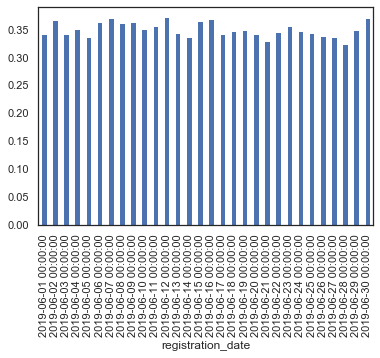

In [30]:
# построим как в зависимости от когорты изменяется Retention Rate на 0-й день в ИЮНЕ:
retention_pivot_june[0].plot.bar()

In [31]:
# Найдем относительное изменение Retention Rate на 7-й день в когорте 30 июня 2019 г. относительно когорты 1 июня 2019 г
print('Относительное изменение Retention Rate на 7-й день в когорте 30 июня относительно 1 июня {:.2%}'.
      format(retention_pivot_june[7]['2019-06-30']/retention_pivot_june[7]['2019-06-01']))

Относительное изменение Retention Rate на 7-й день в когорте 30 июня относительно 1 июня 132.44%


# Задача по retention:
1. Рассчитайте для каждого дня lifetime усредненный Retention Rate по всем когортам июня 2019 г.
2. Постройте график изменения среднего Retention Rate в июне 2019 г. в зависимости от времени жизни пользователя.
3. Опишите, какие выводы можно сделать на основе графика изменения Retention Rate.

### 1. Рассчитаем для каждого дня lifetime усредненный Retention Rate по всем когортам июня 2019 г.

In [32]:
# Создаем dataframe с данными о lifetime и средним значением retention за июнь
avg_retention_june = pd.DataFrame(columns=['lifetime','retention_mean'])
# заполняем данными из сводной таблицы
for i in retention_pivot_june.columns:
    avg_retention_june.loc[i] = [i, retention_pivot_june[i].mean()]
# Приведем lifetime к целому числу
avg_retention_june['lifetime'] = avg_retention_june['lifetime'].astype(int)
# Превратим retantion_rate в настоящие %
avg_retention_june['retention_mean'] = round(avg_retention_june['retention_mean']*100,2)

In [33]:
avg_retention_june.head()

,lifetime,retention_mean
0,0,35.06
1,1,30.57
2,2,22.33
3,3,18.68
4,4,16.16


### 2. Построим график изменения среднего Retention Rate в июне 2019 г. в зависимости от времени жизни пользователя


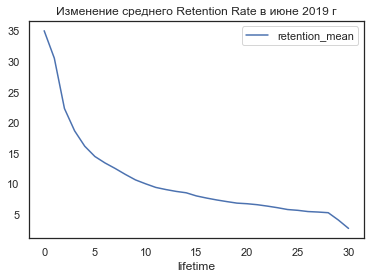

In [34]:
avg_retention_june.plot(x ='lifetime', y='retention_mean', kind = 'line', 
                        title = 'Изменение среднего Retention Rate в июне 2019 г')

### 3. Выводы на основе графика изменения Retention Rate в июне: 
- Показатели Retention Day-1-7-30 ниже стандартных 40-20-10. 
- Показатель удержания первого дня в пределах нормы, а значит на старте игры клиентам она нравится. 
- Однако на 7 день в игру возвращаются около 13% клиентов. Вероятно стоит поработать над среднесрочными целями игроков ,чтобы повысить их мотивацию играть дальше
- На 30й день игрой почти не пользуются. Вероятно она быстро надоедает игрокам, или становится монотонной. Стоит поработать над сюжетом.

# Задача по ARPU:
1. Постройте сводную таблицу, которая отражала бы изменение ARPU по когортам июня 2019 г. в зависимости от времени жизни пользователя.
2. Раскрасьте таблицу тепловой картой с помощью библиотеки seaborn (функцией heatmap).
3. Постройте график ARPU по когортам июня 2019 г. в нулевой день. Оцените, наблюдаются ли на графике какие-то закономерности.
4. Постройте график изменения среднего ARPU по когортам в июне 2019 г. в зависимости от времени жизни пользователя.
5. Опишите, какие выводы можно сделать на основе данных графика. В какие дни наблюдается рост ARPU? В какой из дней наблюдается наибольший рост ARPU?

## Revenue за июнь

In [35]:
# Создаем DataFrame с выручкой по дням в разрезе когорт, для пользователей, зарегистрировавшихся в ИЮНЕ.

def getRevenue_June():
    query = '''SELECT re.date, r.registration_date, count(distinct(re.user_id)) as users_count_with_revenue, sum(re.revenue) as revenue
    FROM case9.user_revenue re
    LEFT JOIN case9.registration r ON r.user_id = re.user_id
    WHERE r.registration_date >= '2019-06-01' and r.registration_date < '2019-07-01'
    GROUP BY 1,2
    '''.format()
    conn = psycopg2.connect("dbname='' user='' host='' password='' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data
revenue_june = pd.DataFrame(getRevenue_June())
for col in ['date','registration_date']:
    revenue_june[col] = pd.to_datetime(revenue_june[col])


In [36]:
# Считаем выручку за июнь
revenue_june['revenue'].sum()

79685.865447

In [37]:
# Считаем среднюю выручку за ИЮНЬ
print(registered_users_count_june['registered_users_count'].sum())

# Считаем среднюю выручку за 30 дней с пользователя, зарегистрировашегося в ИЮНЕ
round(revenue_june['revenue'].sum()/registered_users_count_june['registered_users_count'].sum(),2)

100423


0.79

### ARPU за ИЮНЬ

In [38]:
# Подготовим DataFrame за июнь , который отражает кол-во активных пользователей, ARPU для каждой когорты и каждого дня lifetime

revenue_june = revenue_june.rename(columns={'date':'activity_date'})
retention_table_with_revenue_june = retention_table_june.merge(revenue_june,on=['registration_date','activity_date'],how='left')
# Произведем замену пропущенных значений на 0 с помощью функции fillna():
for col in ['revenue','users_count_with_revenue']:
    retention_table_with_revenue_june[col] = retention_table_with_revenue_june[col].fillna(0)
# Преобразуем тип в колонке users_count_with_revenue в целочисленный
retention_table_with_revenue_june['users_count_with_revenue'] = retention_table_with_revenue_june['users_count_with_revenue'].astype(int)

# рассчитаем ARPU
retention_table_with_revenue_june['arpu'] = retention_table_with_revenue_june['revenue'] / retention_table_with_revenue_june['active_users_count'] 
retention_table_with_revenue_june.head()

,activity_date,registration_date,active_users_count,registered_users_count,retention_rate,lifetime,users_count_with_revenue,revenue,arpu
0,2019-06-01,2019-06-01,1651,4833,0.341610,0,1082,1611.860,0.976293
1,2019-06-02,2019-06-01,1429,4833,0.295676,1,928,317.738,0.222350
2,2019-06-02,2019-06-02,1933,5255,0.367840,0,1257,1305.220,0.675230
3,2019-06-03,2019-06-01,1021,4833,0.211256,2,623,192.273,0.188318
4,2019-06-03,2019-06-02,1550,5255,0.294957,1,1008,554.859,0.357974


### 1. Построим сводную таблицу, которая отражала бы изменение ARPU по когортам июня 2019 г. в зависимости от времени жизни пользователя

In [39]:
# Построим сводную таблицу, которая отражала бы изменение ARPU по когортам июня 2019 г. в зависимости от времени жизни пользователя.
pivot_arpu_lifetime_june = retention_table_with_revenue_june.pivot_table(index='registration_date',
                                                    columns='lifetime',values='arpu',aggfunc='sum')

pivot_arpu_lifetime_june

lifetime,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
registration_date,,,,,,,,,,,,,,,,,,,,,
2019-06-01,0.976293,0.222350,0.188318,0.090474,0.056714,0.215960,0.686825,0.323516,0.000000,0.061368,...,0.058239,0.489990,0.210142,0.021039,0.043126,0.171568,0.769008,0.128948,0.027442,0.403106
2019-06-02,0.675230,0.357974,0.213420,0.126478,0.052536,0.213401,0.083839,0.283805,0.076447,0.215764,...,0.022516,0.022901,0.098184,0.050143,0.805546,0.065083,0.011850,0.054992,0.029301,0.596368
2019-06-03,0.717116,0.243213,0.043576,0.126431,0.093071,0.437531,0.074710,0.057345,0.060045,0.070161,...,0.178001,0.048150,0.322848,0.020926,0.044762,0.051013,0.000000,0.000000,0.034498,0.000000
2019-06-04,0.570125,0.280646,0.156369,0.249738,0.207717,0.313095,0.196367,0.107556,0.201097,0.535641,...,0.036031,0.218364,0.000000,0.035660,0.015292,0.050697,0.000000,0.360193,0.000000,0.050684
2019-06-05,0.678426,0.053987,0.524198,0.164261,0.200625,0.003562,0.066171,0.133804,0.119720,0.465517,...,0.077189,0.039368,0.065654,0.278710,0.040788,0.313618,0.131072,0.363810,0.193209,0.246925
2019-06-06,0.864330,0.156215,0.295781,0.367368,0.192799,0.059184,0.268414,0.059151,0.038135,0.145965,...,0.215097,0.031984,0.108535,0.018374,0.153387,0.303742,0.598917,0.103838,0.101861,0.000000
2019-06-07,0.488339,0.439912,0.276970,0.192135,0.182919,0.572635,0.119355,0.149861,0.071297,0.174512,...,0.131543,0.045359,0.000000,0.114296,0.283932,0.036038,0.125212,1.156721,0.075919,0.067893
2019-06-08,0.653629,0.415474,0.192290,0.268525,0.276235,0.334379,0.235961,0.051926,0.131110,0.264527,...,0.093310,0.000000,0.213927,0.000000,0.084135,0.142929,0.146605,0.000000,0.788146,0.078673
2019-06-09,0.910159,0.186660,0.207617,0.137292,0.441263,0.104410,0.246871,0.360654,0.083993,0.102356,...,0.062687,0.000000,0.028893,0.067952,0.018327,0.041019,0.183464,0.000000,0.016263,0.000000


### 3. Раскрасим таблицу тепловой картой с помощью библиотеки seaborn (функцией heatmap)

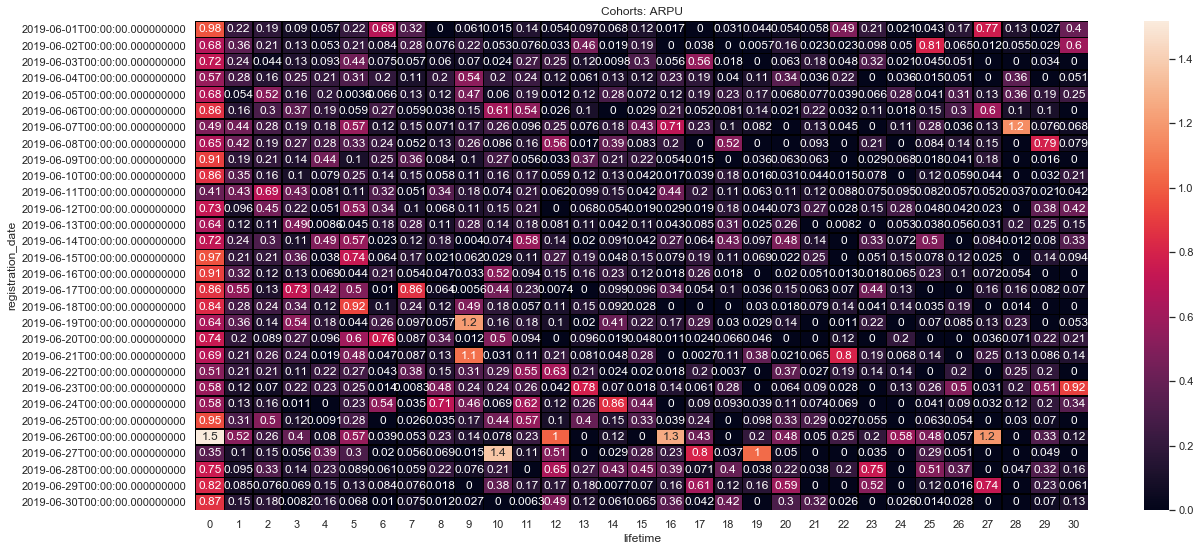

In [40]:
# Раскрасим таблицу тепловой картой с помощью библиотеки seaborn (функцией heatmap)
sns.set(style='white')
plt.figure(figsize=(20, 9))
plt.title('Cohorts: ARPU')
sns.heatmap(pivot_arpu_lifetime_june, mask=pivot_arpu_lifetime_june.isnull(), annot=True, linewidths=0.5, linecolor='black');

## Выводы: 
- ARPU в 0 день использования самый высокий. Значит игроки сразу делают покупку, а дальше уже пользуются игрой.
- Видим с 17-22 июня заметно, что APRU на более длинных периодов заметно вырос. А значит мы стимулировали игроков на дальнейшие покупки. Их активность покупать наши услуги и дальше. 
- В целом изменения в течения июня положительные. ARPU растёт. 

### 3. Построим график ARPU по когортам в 0-й день в июне

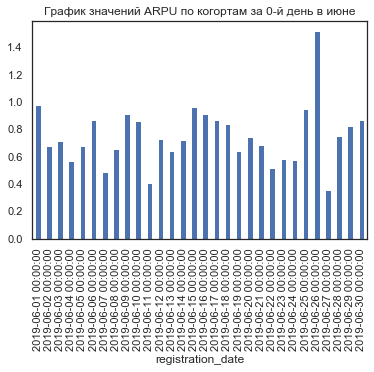

In [41]:
# Построим график ARPU по когортам в 0-й день в июне:
pivot_arpu_lifetime_june[0].plot.bar(title = 'График значений ARPU по когортам за 0-й день в июне')

### Выводы о  графике ARPU 0-го дня в июне: 
- на графике видно, что показатель APRU меняется волнообразно день ото дня. 
- 26 июня был скачёк APRU. Так как мы зарабатываем в основном с 0 дня пользования игрой, то необходимо посмотреть какие действия вызвали скачёк ARPU, чтобы повторить эти такой скачёк или сделать их более регулярными.  

### 4. Построим  график изменения среднего ARPU по когортам в июне 2019 г. в зависимости от времени жизни пользователя.

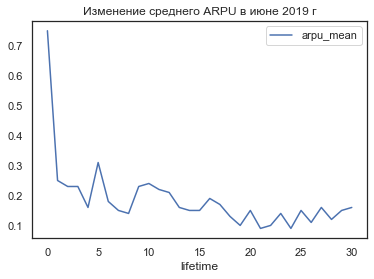

In [42]:
# Построим  график изменения среднего ARPU по когортам в июне 2019 г. в зависимости от времени жизни пользователя.

# Создаем dataframe с данными о lifetime и средним значением arpu за июнь
avg_arpu_june = pd.DataFrame(columns=['lifetime','arpu_mean'])
# заполняем данными из сводной таблицы
for i in pivot_arpu_lifetime_june.columns:
    avg_arpu_june.loc[i] = [i, pivot_arpu_lifetime_june[i].mean()]
# Приведем lifetime к целому числу
avg_arpu_june['lifetime'] = avg_retention_june['lifetime'].astype(int)
# Округлим среднее ARPU до копеек
avg_arpu_june['arpu_mean'] = round(avg_arpu_june['arpu_mean'],2)
# Строим график
avg_arpu_june.plot(x ='lifetime', y='arpu_mean', kind = 'line', 
                        title = 'Изменение среднего ARPU в июне 2019 г')

### 5. Выводы об изменении среднего ARPU за июнь:
- рост ARPU наблюдается на 5, 10 16 день пользования игрой. Далее APRU стабилизируется. 
- наибольший рост ARPU наблюдается на 5й день пользования игрой. 
- Видно, что игрокам необходимо периодически что-то покупать в игре, и эти покупки явно коррелируют с днем нахождения в игре. 